<a href="https://colab.research.google.com/github/forumb94/energypricecode/blob/main/maincode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install plotly

# tensorflow-addons version depends on the tensorflow and python version of the system,
# you can find the compatibility in this link

# https://stackoverflow.com/questions/61380552/unable-to-import-tensorflow-addons
#!pip install tensorflow-addons
#!pip install --upgrade tensorflow
#!pip install --upgrade keras
#!pip install --upgrade tensorflow-addons
#!pip install tensorflow-addons==0.21.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.23.0
    Uninstalling tensorflow-addons-0.23.0:
      Successfully uninstalled tensorflow-addons-0.23.0


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import io

import numpy as np
import math
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
#import tensorflow_addons as tfa


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

In [7]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('final_merged_data_V1.csv')

Saving final_merged_data_V1.csv to final_merged_data_V1 (1).csv


In [9]:
# Read the dataset
df = pd.read_csv(io.BytesIO(uploaded['final_merged_data_V1 (1).csv']))

In [10]:
# Convert 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce')

# Fill missing values for numeric columns using forward fill, then backward fill as backup
numeric_cols = df.select_dtypes(include=["number"]).columns
df[numeric_cols] = df[numeric_cols].ffill().bfill()

# Drop unnecessary columns
#df.drop(columns=['Local Date', 'Hour Number'], inplace=True, errors='ignore')

# Display dataset info
print(df.info())

# Display first few rows
print(df.head())

# Generate summary statistics
summary_stats = df.describe().T
missing_values = df.isnull().sum()
unique_counts = df.nunique()

# Display key statistics
print("\nSummary Statistics:")
print(summary_stats)

print("\nMissing Values Per Column:")
print(missing_values[missing_values > 0])

print("\nUnique Value Counts for Categorical Columns:")
print(unique_counts)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35081 entries, 0 to 35080
Data columns (total 58 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   Local Date                                            35081 non-null  object        
 1   Hour Number                                           35081 non-null  int64         
 2   Time                                                  0 non-null      datetime64[ns]
 3   Total Generation (MW)                                 35081 non-null  float64       
 4   Dual Fuel Generation (MW)                             35081 non-null  float64       
 5   Hydro Generation (MW)                                 35081 non-null  float64       
 6   Natural Gas Generation (MW)                           35081 non-null  float64       
 7   Nuclear Generation (MW)                               35081 non-null  float6

In [11]:
print(df.columns)

Index(['Local Date', 'Hour Number', 'Time', 'Total Generation (MW)',
       'Dual Fuel Generation (MW)', 'Hydro Generation (MW)',
       'Natural Gas Generation (MW)', 'Nuclear Generation (MW)',
       'Other Fossil Fuels Generation (MW)',
       'Other Renewables Generation (MW)', 'Wind Generation (MW)',
       'DAMP A - West', 'DAMP B - Genessee', 'DAMP C - Central',
       'DAMP D - North', 'DAMP E - Mohawk Valley', 'DAMP F - Capital',
       'DAMP G - Hudson Valley', 'DAMP H - Millwood', 'DAMP I - Dunwoodie',
       'DAMP J - New York City', 'DAMP K - Long Island',
       'F - Capital Actual Load (MW)', 'C - Central Actual Load (MW)',
       'I - Dunwoodie Actual Load (MW)', 'B - Genessee Actual Load (MW)',
       'G - Hudson Valley Actual Load (MW)',
       'K - Long Island Actual Load (MW)',
       'E - Mohawk Valley Actual Load (MW)', 'H - Millwood Actual Load (MW)',
       'J - New York City Actual Load (MW)', 'D - North Actual Load (MW)',
       'A - West Actual Load (MW)', 'N

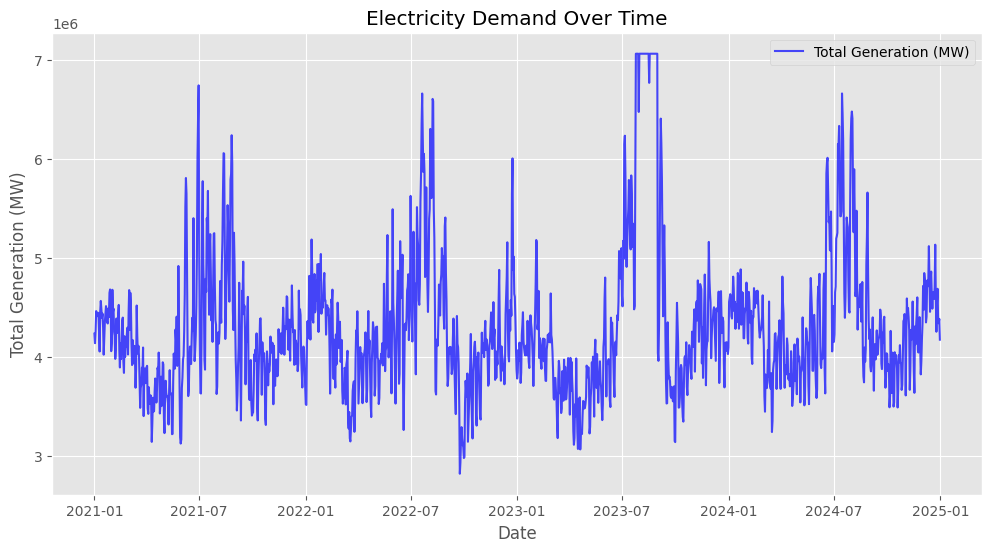

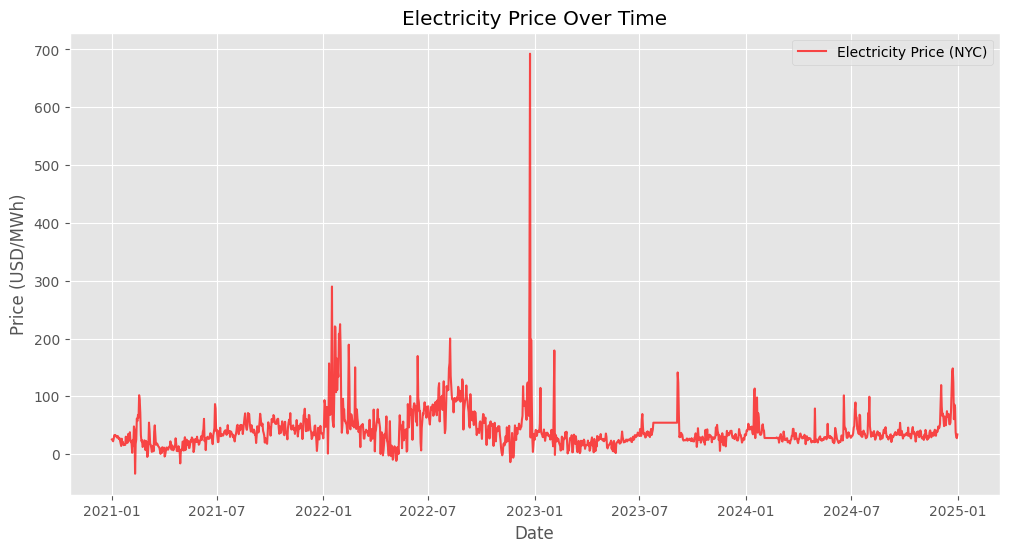

In [13]:
# Convert date column to datetime format for time-series analysis
df['Local Date'] = pd.to_datetime(df['Local Date'])

# Aggregate data by day for visualization
daily_demand = df.groupby('Local Date')['Total Generation (MW)'].sum()
daily_price = df.groupby('Local Date')['Real Time J - New York City'].mean()  # Using NYC as a representative price

# Plot electricity demand over time
plt.figure(figsize=(12, 6))
plt.plot(daily_demand, label='Total Generation (MW)', color='blue', alpha=0.7)
plt.title('Electricity Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Total Generation (MW)')
plt.legend()
plt.grid(True)
plt.show()

# Plot electricity price over time
plt.figure(figsize=(12, 6))
plt.plot(daily_price, label='Electricity Price (NYC)', color='red', alpha=0.7)
plt.title('Electricity Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD/MWh)')
plt.legend()
plt.grid(True)
plt.show()


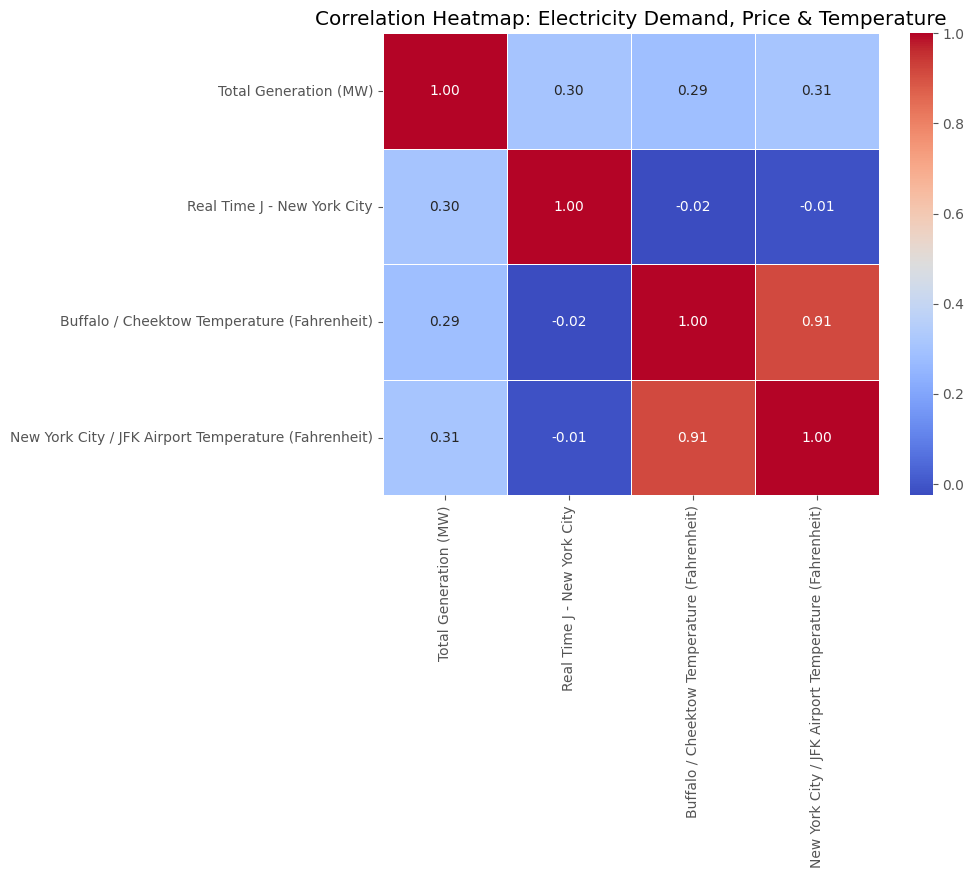

In [14]:
# Compute correlation matrix for relevant numerical variables
relevant_columns = ['Total Generation (MW)', 'Real Time J - New York City',
                    'Buffalo / Cheektow Temperature (Fahrenheit)',
                    'New York City / JFK Airport Temperature (Fahrenheit)']
correlation_matrix = df[relevant_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Electricity Demand, Price & Temperature")
plt.show()


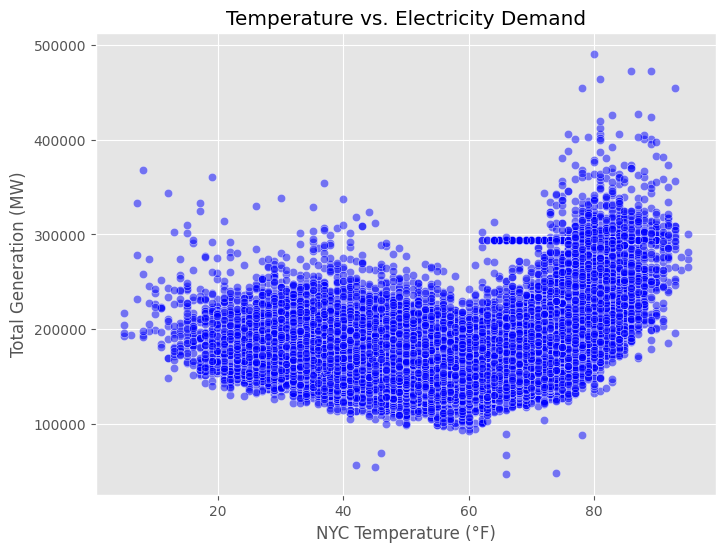

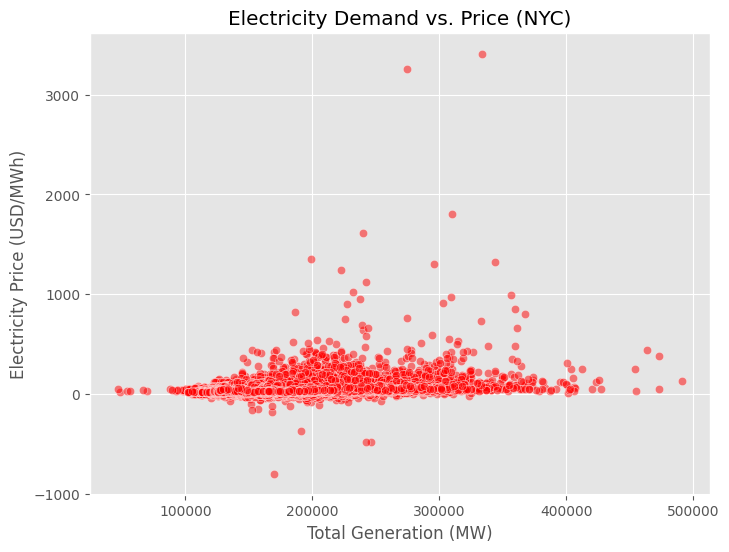

In [15]:
# Scatter plot: Temperature vs. Electricity Demand
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['New York City / JFK Airport Temperature (Fahrenheit)'],
                y=df['Total Generation (MW)'], alpha=0.5, color='blue')
plt.title("Temperature vs. Electricity Demand")
plt.xlabel("NYC Temperature (°F)")
plt.ylabel("Total Generation (MW)")
plt.grid(True)
plt.show()

# Scatter plot: Electricity Demand vs. Price
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Total Generation (MW)'],
                y=df['Real Time J - New York City'], alpha=0.5, color='red')
plt.title("Electricity Demand vs. Price (NYC)")
plt.xlabel("Total Generation (MW)")
plt.ylabel("Electricity Price (USD/MWh)")
plt.grid(True)
plt.show()


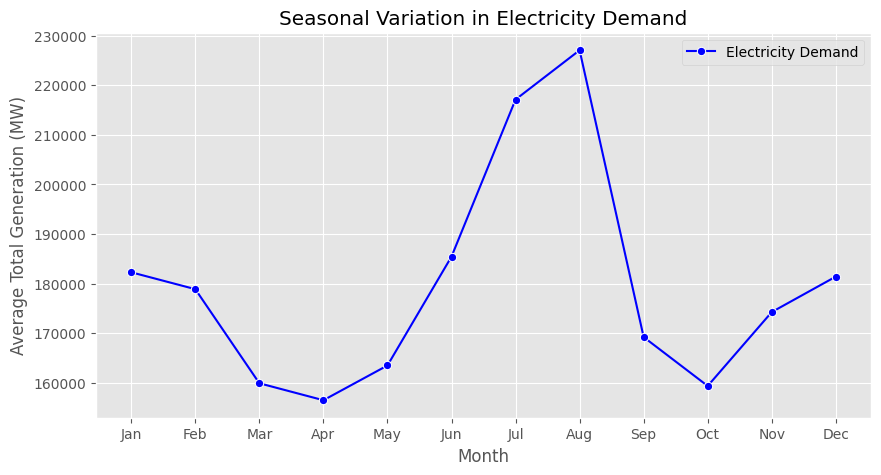

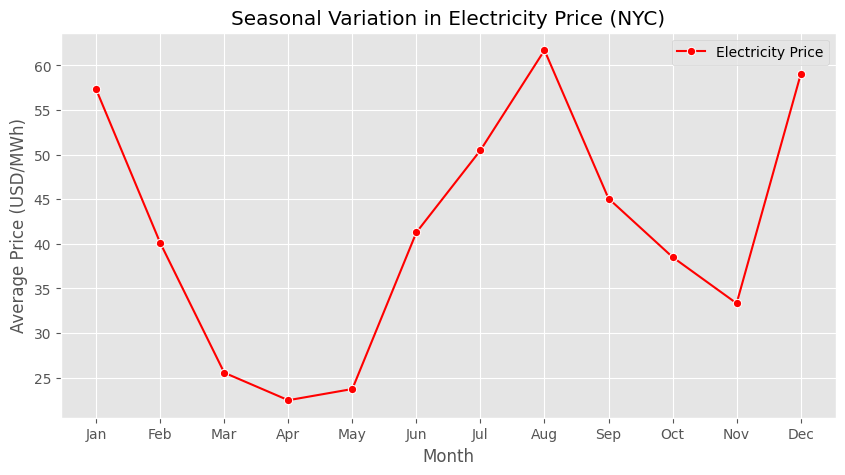

In [16]:
# Extract month from date for seasonal analysis
df['Month'] = df['Local Date'].dt.month

# Aggregate data by month
monthly_demand = df.groupby('Month')['Total Generation (MW)'].mean()
monthly_price = df.groupby('Month')['Real Time J - New York City'].mean()

# Plot seasonal electricity demand trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_demand.index, y=monthly_demand.values, marker='o', color='blue', label="Electricity Demand")
plt.title("Seasonal Variation in Electricity Demand")
plt.xlabel("Month")
plt.ylabel("Average Total Generation (MW)")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend()
plt.show()

# Plot seasonal electricity price trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_price.index, y=monthly_price.values, marker='o', color='red', label="Electricity Price")
plt.title("Seasonal Variation in Electricity Price (NYC)")
plt.xlabel("Month")
plt.ylabel("Average Price (USD/MWh)")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend()
plt.show()
